In [8]:
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageChops
import numpy as np
import os
import math
import copy

In [9]:
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.transforms as transforms
import torchvision.models as models

In [10]:
device = torch.device("cuda")

In [11]:
#imsize = 256
mean = torch.tensor([0.485, 0.456, 0.406]).cpu().view(-1,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).cpu().view(-1,1,1)

### Helper Functions

In [24]:
def file_to_tensor(file_path):
    global imsize
    image = Image.open(file_path)
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def image_to_tensor(image):
    global imsize
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).cpu()
    ten_image = preprocess_tensor(ten_image)
    ten_image = ten_image.clone().to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def tensor_to_image(tensor):
    tensor = tensor.clone().squeeze(0)
    tensor = deprocess_tensor(tensor.clone().cpu()).detach().numpy()
    tensor = np.clip(tensor, 0, 1)
    tensor = np.uint8(tensor*255)
    tensor = torch.from_numpy(tensor).cpu()
    tensor = tensor.type(torch.ByteTensor)
    #img = Image.fromarray(np.uint8(tensor*255))
    img = transforms.ToPILImage()(tensor)
    return img

In [25]:
def preprocess_tensor(img_tensor):
    global mean, std
    #print(type(img_tensor), type(std), type(mean))
    return (img_tensor - mean)/std

In [26]:
def deprocess_tensor(img_tensor):
    global mean, std
    #print(type(img_tensor), type(std), type(mean))
    return img_tensor * std  + mean

### Main Functions

In [92]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()
module_list = list(vgg.modules())
print(module_list)

[Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [114]:
# rn = models.inception_v3(pretrained=True).features.to(device).eval()
# module_list = list(vgg.modules())
# print(module_list)

In [16]:
def objective_function():
    pass

In [94]:
def dream(net, depth, image, iterations, lr):
    net.zero_grad()
    image_tensor = Variable(image_to_tensor(image), requires_grad=True)
    #print(image_tensor.is_leaf)
    for i in range(iterations):
        out = image_tensor
        for i in range(depth):
            out = module_list[i+1](out)
        loss = out.norm()
        loss.backward()
        image_tensor.data = image_tensor.data + lr*image_tensor.grad.data
    image = tensor_to_image(image_tensor.clone())
    return image

In [191]:
def set_octaves(net, depth, image, iterations, lr, octave_scale, num_octaves, blur, blend_factor):
    if num_octaves >=1:
        use_image = image.filter(ImageFilter.GaussianBlur(blur))
        if min(np.asarray(use_image.size)/octave_scale) < 1:
            size = use_image.size
        else:
            size = (use_image.size[0]//octave_scale, use_image.size[1]//octave_scale)
        use_image = use_image.resize(size)
        use_image = set_octaves(net, depth, use_image, iterations, lr, octave_scale, num_octaves-1, blur+0.25, blend_factor)
        size = image.size
        use_image = use_image.resize(size)
        image = ImageChops.blend(image, use_image, blend_factor)
    final_image = dream(net, depth, image, iterations, lr)
    final_image = final_image.resize(image.size)
    return final_image

In [217]:
file_path = "DreamSet/starry_night.jpg"
image = Image.open(file_path)

In [221]:
layer = 29
fim = set_octaves(net=vgg, depth=layer, image=image, iterations=4, lr=0.2, octave_scale=2, 
                  num_octaves=20, blur=0.5, blend_factor=0.5)

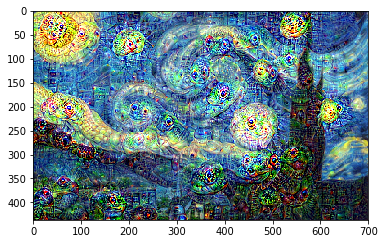

In [222]:
plt.imshow(fim)

In [223]:
new_path = file_path.split('.')[0]+'_dream_'+str(layer)+'.png'
fim.save(new_path)